In [3]:
import pandas as pd
import numpy as np

train_df = pd.read_csv('../data/train.csv')
store_df = pd.read_csv('../data/store.csv')
test_df = pd.read_csv('../data/test.csv')

/home/mlp/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 100)
pd.set_option('expand_frame_repr', False)
pd.set_option('precision', 6)

In [5]:
train_df = train_df.merge(store_df, on='Store', how='left')
test_df = test_df.merge(store_df, on='Store', how='left')


### Data Clean

In [8]:
def data_clean(df):
    df['Assortment'] = df['Assortment'].astype('str')
    df['StoreType'] = df['StoreType'].astype('str')
    df['StateHoliday'] = df['StateHoliday'].astype('str')

    df['CompetitionDistance'] = df.CompetitionDistance.fillna(0)

    df['CompetitionOpenSinceYear'] = df.CompetitionOpenSinceYear.fillna(1900).astype(np.int32)
    df['CompetitionOpenSinceMonth'] = df.CompetitionOpenSinceMonth.fillna(1).astype(np.int32)
    df['Promo2SinceYear'] = df.Promo2SinceYear.fillna(1900).astype(np.int32)
    df['Promo2SinceWeek'] = df.Promo2SinceWeek.fillna(1).astype(np.int32)
    
    df['Date'] = pd.to_datetime(df['Date'])
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month

    
    return df

train_df = data_clean(train_df)
test_df = data_clean(test_df)

### Sales Features Extraction

In [42]:
train_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9,2008,0,1,1900,NaN,2015,7
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",2015,7
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",2015,7
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9,2009,0,1,1900,NaN,2015,7
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4,2015,0,1,1900,NaN,2015,7


In [9]:
sales_feature_df = train_df

history_dow_sales_df = sales_feature_df.loc[(sales_feature_df['Open'] == 1) & (sales_feature_df['Sales'] > 0)]

history_dow_sales_df = history_dow_sales_df.groupby(['Store', 'DayOfWeek', 'Year', 'Month']).agg({'Sales':'mean'}).reset_index()

history_dow_sales_df = history_dow_sales_df.sort_values(by=['Store', 'DayOfWeek', 'Year', 'Month'])

history_dow_sales_df.head(10)



,Store,DayOfWeek,Year,Month,Sales
0,1,1,2013,1,5335.500000
1,1,1,2013,2,5471.500000
2,1,1,2013,3,6606.250000
3,1,1,2013,4,5370.000000
4,1,1,2013,5,5397.666667
5,1,1,2013,6,4649.750000
6,1,1,2013,7,5381.000000
7,1,1,2013,8,4712.000000
8,1,1,2013,9,4639.000000
9,1,1,2013,10,4597.250000


In [10]:
def sales_feature_extraction_02(df):

    ahead_2m_dow_sales = df[['Store', 'DayOfWeek', 'Sales']].groupby(["Store", "DayOfWeek"])['Sales'].rolling(2, min_periods=2).sum().reset_index()
    ahead_4m_dow_sales = df[['Store', 'DayOfWeek','Sales']].groupby(["Store", "DayOfWeek"])['Sales'].rolling(4, min_periods=4).sum().reset_index()
    ahead_5m_dow_sales = df[['Store', 'DayOfWeek','Sales']].groupby(["Store", "DayOfWeek"])['Sales'].rolling(5, min_periods=5).sum().reset_index()
    ahead_7m_dow_sales = df[['Store', 'DayOfWeek','Sales']].groupby(["Store", "DayOfWeek"])['Sales'].rolling(7, min_periods=7).sum().reset_index()
    ahead_8m_dow_sales = df[['Store', 'DayOfWeek','Sales']].groupby(["Store", "DayOfWeek"])['Sales'].rolling(8, min_periods=8).sum().reset_index()
    ahead_13m_dow_sales = df[['Store', 'DayOfWeek','Sales']].groupby(["Store", "DayOfWeek"])['Sales'].rolling(13, min_periods=13).sum().reset_index()
    ahead_14m_dow_sales = df[['Store', 'DayOfWeek','Sales']].groupby(["Store", "DayOfWeek"])['Sales'].rolling(14, min_periods=14).sum().reset_index()

    sales_merge_df = df.merge(ahead_4m_dow_sales, left_index=True, right_index=True, suffixes=("", "_sum_4m"))
    sales_merge_df = sales_merge_df.merge(ahead_5m_dow_sales, left_index=True, right_index=True, suffixes=("", "_sum_5m"))
    sales_merge_df = sales_merge_df.merge(ahead_2m_dow_sales, left_index=True, right_index=True, suffixes=("", "_sum_2m"))
    sales_merge_df = sales_merge_df.merge(ahead_7m_dow_sales, left_index=True, right_index=True, suffixes=("", "_sum_7m"))
    sales_merge_df = sales_merge_df.merge(ahead_8m_dow_sales, left_index=True, right_index=True, suffixes=("", "_sum_8m"))
    sales_merge_df = sales_merge_df.merge(ahead_13m_dow_sales, left_index=True, right_index=True, suffixes=("", "_sum_13m"))
    sales_merge_df = sales_merge_df.merge(ahead_14m_dow_sales, left_index=True, right_index=True, suffixes=("", "_sum_14m"))

    sales_merge_df = sales_merge_df.drop(['Store_sum_4m', 'DayOfWeek_sum_4m', 'level_2', 'Store_sum_5m', 'DayOfWeek_sum_5m', 'level_2_sum_5m', 'Store_sum_2m', 'DayOfWeek_sum_2m', 'level_2_sum_2m', 'Store_sum_7m', 'DayOfWeek_sum_7m', 'level_2_sum_7m', 'Store_sum_8m', 'DayOfWeek_sum_8m', 'level_2_sum_8m', 'Store_sum_13m', 'DayOfWeek_sum_13m', 'level_2_sum_13m', 'Store_sum_14m', 'DayOfWeek_sum_14m', 'level_2_sum_14m'], axis=1)

    sales_merge_df['mean_dow_sales_3mb'] = (sales_merge_df['Sales_sum_4m'] - sales_merge_df['Sales'])/3
    sales_merge_df['mean_dow_sales_1m_ago_3mb'] = (sales_merge_df['Sales_sum_5m'] - sales_merge_df['Sales_sum_2m'])/3
    sales_merge_df['mean_dow_sales_6mb'] = (sales_merge_df['Sales_sum_7m'] - sales_merge_df['Sales'])/6
    sales_merge_df['mean_dow_sales_1m_ago_6mb'] = (sales_merge_df['Sales_sum_8m'] - sales_merge_df['Sales_sum_2m'])/6
    sales_merge_df['mean_dow_sales_12mb'] = (sales_merge_df['Sales_sum_13m'] - sales_merge_df['Sales'])/12
    sales_merge_df['mean_dow_sales_1m_ago_12mb'] = (sales_merge_df['Sales_sum_14m'] - sales_merge_df['Sales_sum_2m'])/12

    sales_merge_df = sales_merge_df.drop(['Sales_sum_4m', 'Sales_sum_5m', 'Sales_sum_2m', 'Sales_sum_7m', 'Sales_sum_8m', 'Sales_sum_13m', 'Sales_sum_14m'], axis=1)
    sales_merge_df = sales_merge_df.dropna()
    
    return sales_merge_df

history_dow_sales_feature_df = sales_feature_extraction_02(history_dow_sales_df)

In [19]:
sales_feature_df['isStateHoliday'] = sales_feature_df['StateHoliday'] != '0'

history_dph_sales_df = sales_feature_df.loc[(sales_feature_df['Open'] == 1) & (sales_feature_df['Outlier'] == False) & (sales_feature_df['Sales'] > 0)]

history_dph_sales_df = history_dph_sales_df.groupby(['Store', 'DayOfWeek', 'Promo', 'isStateHoliday','Year', 'Month']).agg({'Sales':'mean'}).reset_index()

history_dph_sales_df = history_dph_sales_df.sort_values(by=['Store', 'DayOfWeek', 'Promo', 'isStateHoliday', 'Year', 'Month'])

history_dph_sales_df.head()


,Store,DayOfWeek,Promo,isStateHoliday,Year,Month,Sales
0,1,1,0,False,2013,1,4386.0
1,1,1,0,False,2013,2,4223.5
2,1,1,0,False,2013,3,4949.0
3,1,1,0,False,2013,4,3941.0
4,1,1,0,False,2013,5,4568.0


In [20]:
def sales_feature_extraction_03(df):

    ahead_2m_dph_sales = df[['Store', 'DayOfWeek', 'Promo', 'isStateHoliday', 'Sales']].groupby(["Store", "DayOfWeek", "Promo", "isStateHoliday"])['Sales'].rolling(2, min_periods=2).sum().reset_index()
    ahead_4m_dph_sales = df[['Store', 'DayOfWeek','Promo', 'isStateHoliday', 'Sales']].groupby(["Store", "DayOfWeek", "Promo", "isStateHoliday"])['Sales'].rolling(4, min_periods=4).sum().reset_index()
    ahead_5m_dph_sales = df[['Store', 'DayOfWeek','Promo', 'isStateHoliday', 'Sales']].groupby(["Store", "DayOfWeek", "Promo", "isStateHoliday"])['Sales'].rolling(5, min_periods=5).sum().reset_index()
    ahead_7m_dph_sales = df[['Store', 'DayOfWeek','Promo', 'isStateHoliday', 'Sales']].groupby(["Store", "DayOfWeek", "Promo", "isStateHoliday"])['Sales'].rolling(7, min_periods=7).sum().reset_index()
    ahead_8m_dph_sales = df[['Store', 'DayOfWeek','Promo', 'isStateHoliday', 'Sales']].groupby(["Store", "DayOfWeek", "Promo", "isStateHoliday"])['Sales'].rolling(8, min_periods=8).sum().reset_index()
    ahead_13m_dph_sales = df[['Store', 'DayOfWeek','Promo', 'isStateHoliday', 'Sales']].groupby(["Store", "DayOfWeek", "Promo", "isStateHoliday"])['Sales'].rolling(13, min_periods=13).sum().reset_index()
    ahead_14m_dph_sales = df[['Store', 'DayOfWeek','Promo', 'isStateHoliday', 'Sales']].groupby(["Store", "DayOfWeek", "Promo", "isStateHoliday"])['Sales'].rolling(14, min_periods=14).sum().reset_index()

    sales_merge_df = df.merge(ahead_4m_dph_sales, left_index=True, right_index=True, suffixes=("", "_sum_4m"))
    sales_merge_df = sales_merge_df.merge(ahead_5m_dph_sales, left_index=True, right_index=True, suffixes=("", "_sum_5m"))
    sales_merge_df = sales_merge_df.merge(ahead_2m_dph_sales, left_index=True, right_index=True, suffixes=("", "_sum_2m"))
    sales_merge_df = sales_merge_df.merge(ahead_7m_dph_sales, left_index=True, right_index=True, suffixes=("", "_sum_7m"))
    sales_merge_df = sales_merge_df.merge(ahead_8m_dph_sales, left_index=True, right_index=True, suffixes=("", "_sum_8m"))
    sales_merge_df = sales_merge_df.merge(ahead_13m_dph_sales, left_index=True, right_index=True, suffixes=("", "_sum_13m"))
    sales_merge_df = sales_merge_df.merge(ahead_14m_dph_sales, left_index=True, right_index=True, suffixes=("", "_sum_14m"))

    sales_merge_df = sales_merge_df.drop(['Store_sum_4m', 'DayOfWeek_sum_4m', 'Promo_sum_4m', 'isStateHoliday_sum_4m', 'level_4', 'Store_sum_5m', 'DayOfWeek_sum_5m', 'Promo_sum_5m', 'isStateHoliday_sum_5m', 'level_4_sum_5m', 'Store_sum_2m', 'DayOfWeek_sum_2m', 'Promo_sum_2m', 'isStateHoliday_sum_2m', 'level_4_sum_2m', 'Store_sum_7m', 'DayOfWeek_sum_7m', 'Promo_sum_7m', 'isStateHoliday_sum_7m', 'level_4_sum_7m', 'Store_sum_8m', 'DayOfWeek_sum_8m', 'Promo_sum_8m', 'isStateHoliday_sum_8m', 'level_4_sum_8m', 'Store_sum_13m', 'DayOfWeek_sum_13m', 'Promo_sum_13m', 'isStateHoliday_sum_13m', 'level_4_sum_13m', 'Store_sum_14m', 'DayOfWeek_sum_14m', 'Promo_sum_14m', 'isStateHoliday_sum_14m', 'level_4_sum_14m'], axis=1)

    sales_merge_df['mean_dph_sales_3mb'] = (sales_merge_df['Sales_sum_4m'] - sales_merge_df['Sales'])/3
    sales_merge_df['mean_dph_sales_1m_ago_3mb'] = (sales_merge_df['Sales_sum_5m'] - sales_merge_df['Sales_sum_2m'])/3
    sales_merge_df['mean_dph_sales_6mb'] = (sales_merge_df['Sales_sum_7m'] - sales_merge_df['Sales'])/6
    sales_merge_df['mean_dph_sales_1m_ago_6mb'] = (sales_merge_df['Sales_sum_8m'] - sales_merge_df['Sales_sum_2m'])/6
    sales_merge_df['mean_dph_sales_12mb'] = (sales_merge_df['Sales_sum_13m'] - sales_merge_df['Sales'])/12
    sales_merge_df['mean_dph_sales_1m_ago_12mb'] = (sales_merge_df['Sales_sum_14m'] - sales_merge_df['Sales_sum_2m'])/12

    sales_merge_df = sales_merge_df.drop(['Sales_sum_4m', 'Sales_sum_5m', 'Sales_sum_2m', 'Sales_sum_7m', 'Sales_sum_8m', 'Sales_sum_13m', 'Sales_sum_14m'], axis=1)
    sales_merge_df = sales_merge_df.dropna()
    
    return sales_merge_df

history_dph_sales_feature_df = sales_feature_extraction_03(history_dph_sales_df)

In [21]:
history_dph_sales_feature_df.head()

,Store,DayOfWeek,Promo,isStateHoliday,Year,Month,Sales,mean_dph_sales_3mb,mean_dph_sales_1m_ago_3mb,mean_dph_sales_6mb,mean_dph_sales_1m_ago_6mb,mean_dph_sales_12mb,mean_dph_sales_1m_ago_12mb
13,1,1,0,False,2014,2,3708.5,4644.000000,4599.833333,4299.055556,4384.805556,4308.986111,4358.027778
14,1,1,0,False,2014,3,3711.5,4444.500000,4644.000000,4247.138889,4299.055556,4266.069444,4308.986111
15,1,1,0,False,2014,4,3751.0,3739.166667,4444.500000,4169.500000,4247.138889,4162.944444,4266.069444
16,1,1,0,False,2014,5,3934.5,3723.666667,3739.166667,4183.833333,4169.500000,4147.111111,4162.944444
17,1,1,0,False,2014,6,3755.0,3799.000000,3723.666667,4121.750000,4183.833333,4094.319444,4147.111111


In [11]:
history_dow_sales_feature_df.head()

,Store,DayOfWeek,Year,Month,Sales,mean_dow_sales_3mb,mean_dow_sales_1m_ago_3mb,mean_dow_sales_6mb,mean_dow_sales_1m_ago_6mb,mean_dow_sales_12mb,mean_dow_sales_1m_ago_12mb
13,1,1,2014,2,4662.250000,5788.450000,5659.450000,5218.933333,5285.058333,5349.147222,5378.418056
14,1,1,2014,3,5038.400000,5642.366667,5788.450000,5210.641667,5218.933333,5281.709722,5349.147222
15,1,1,2014,4,5347.333333,4894.966667,5642.366667,5277.208333,5210.641667,5151.055556,5281.709722
16,1,1,2014,5,4707.750000,5015.994444,4894.966667,5402.222222,5277.208333,5149.166667,5151.055556
17,1,1,2014,6,5088.000000,5031.161111,5015.994444,5336.763889,5402.222222,5091.673611,5149.166667


In [50]:
# Merge history sales features

train_val_set = sales_feature_df.loc[(sales_feature_df['Open'] == 1) & (sales_feature_df['Sales'] > 0)]
train_val_set = train_val_set.merge(history_dow_sales_feature_df.drop(['Sales'], axis= 1), how='inner', on=['Store', 'DayOfWeek', 'Year', 'Month'])
train_val_set.head()


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,isPromoMonth,mean_dow_sales_3mb,mean_dow_sales_1m_ago_3mb,mean_dow_sales_6mb,mean_dow_sales_1m_ago_6mb,mean_dow_sales_12mb,mean_dow_sales_1m_ago_12mb
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9,2008,0,1,1900,,2015,7,0,4155.055556,4203.888889,4350.686111,4716.547222,4546.690278,4601.711111
1,1,5,2015-07-24,3706,459,1,0,0,0,c,a,1270.0,9,2008,0,1,1900,,2015,7,0,4155.055556,4203.888889,4350.686111,4716.547222,4546.690278,4601.711111
2,1,5,2015-07-17,4852,519,1,1,0,0,c,a,1270.0,9,2008,0,1,1900,,2015,7,0,4155.055556,4203.888889,4350.686111,4716.547222,4546.690278,4601.711111
3,1,5,2015-07-10,3808,449,1,0,0,0,c,a,1270.0,9,2008,0,1,1900,,2015,7,0,4155.055556,4203.888889,4350.686111,4716.547222,4546.690278,4601.711111
4,1,5,2015-07-03,4665,538,1,1,0,0,c,a,1270.0,9,2008,0,1,1900,,2015,7,0,4155.055556,4203.888889,4350.686111,4716.547222,4546.690278,4601.711111


In [14]:
# Merge event features
event_feature_df = pd.read_csv('../event_feature.csv')

event_feature_df.head()


,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Customers,Date,DayOfWeek,Open,Promo,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Sales,SchoolHoliday,StateHoliday,Store,StoreType,data_type,Year,Month,CompetitionOpenDate,DaysAfterCompetitionOpen,MonthAfterCompetitionOpen,Promo2Since,DaysAfterPromo2,WeekAfterPromo2,isStateHoliday,isSchoolHoliday,isPromo,daysAfterStateHoliday,daysAfterSchoolHoliday,daysAfterPromo,daysBeforeStateHoliday,daysBeforeSchoolHoliday,daysBeforePromo,StateHolidayDay,last_7d_state_holiday,last_7d_school_holiday,last_7d_promo,coming_7d_state_holiday,coming_7d_school_holiday,coming_7d_promo
0,a,1270.0,9,2008,NaN,2015-09-17,4,1.0,1,0,1,1900,NaN,NaN,0,0,1,c,3,2015,9,2008-09-15,2558,24,1900-01-01,0,0,False,False,True,105.0,13.0,0.0,-1.0,-1.0,0.0,0,0.0,0.0,4.0,0.0,0.0,1.0
1,a,1270.0,9,2008,NaN,2015-09-16,3,1.0,1,0,1,1900,NaN,NaN,0,0,1,c,3,2015,9,2008-09-15,2557,24,1900-01-01,0,0,False,False,True,104.0,12.0,0.0,-1.0,-1.0,0.0,0,0.0,0.0,3.0,0.0,0.0,2.0
2,a,1270.0,9,2008,NaN,2015-09-15,2,1.0,1,0,1,1900,NaN,NaN,0,0,1,c,3,2015,9,2008-09-15,2556,24,1900-01-01,0,0,False,False,True,103.0,11.0,0.0,-1.0,-1.0,0.0,0,0.0,0.0,2.0,0.0,0.0,3.0
3,a,1270.0,9,2008,NaN,2015-09-14,1,1.0,1,0,1,1900,NaN,NaN,0,0,1,c,3,2015,9,2008-09-15,2555,24,1900-01-01,0,0,False,False,True,102.0,10.0,0.0,-1.0,-1.0,0.0,0,0.0,0.0,1.0,0.0,0.0,4.0
4,a,1270.0,9,2008,NaN,2015-09-13,7,0.0,0,0,1,1900,NaN,NaN,0,0,1,c,3,2015,9,2008-09-15,2554,24,1900-01-01,0,0,False,False,False,101.0,9.0,9.0,-1.0,-1.0,1.0,0,0.0,0.0,0.0,0.0,0.0,4.0


In [51]:
# event_features = ["MonthAfterCompetitionOpen", "WeekAfterPromo2", "daysAfterStateHoliday", "daysAfterSchoolHoliday", "daysAfterPromo", "daysBeforeStateHoliday", "daysBeforeSchoolHoliday", "daysBeforePromo", "last_7d_state_holiday", "last_7d_school_holiday", "last_7d_promo", "coming_7d_state_holiday", "coming_7d_school_holiday", "coming_7d_promo"]

event_features = ["MonthAfterCompetitionOpen", "DaysAfterPromo2", "WeekAfterPromo2", "daysAfterStateHoliday", "daysAfterSchoolHoliday", "daysAfterPromo", "last_7d_state_holiday", "last_7d_school_holiday", "last_7d_promo"]

event_feature_df['Date'] = pd.to_datetime(event_feature_df['Date'])

train_val_set = train_val_set.merge(event_feature_df[['Store', 'Date'] + event_features], how='inner', on =['Store', 'Date'])

train_val_set.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,isPromoMonth,mean_dow_sales_3mb,mean_dow_sales_1m_ago_3mb,mean_dow_sales_6mb,mean_dow_sales_1m_ago_6mb,mean_dow_sales_12mb,mean_dow_sales_1m_ago_12mb,MonthAfterCompetitionOpen,DaysAfterPromo2,WeekAfterPromo2,daysAfterStateHoliday,daysAfterSchoolHoliday,daysAfterPromo,last_7d_state_holiday,last_7d_school_holiday,last_7d_promo
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9,2008,0,1,1900,,2015,7,0,4155.055556,4203.888889,4350.686111,4716.547222,4546.690278,4601.711111,24,0,0,57.0,0.0,0.0,0.0,5.0,5.0
1,1,5,2015-07-24,3706,459,1,0,0,0,c,a,1270.0,9,2008,0,1,1900,,2015,7,0,4155.055556,4203.888889,4350.686111,4716.547222,4546.690278,4601.711111,24,0,0,50.0,105.0,7.0,0.0,0.0,0.0
2,1,5,2015-07-17,4852,519,1,1,0,0,c,a,1270.0,9,2008,0,1,1900,,2015,7,0,4155.055556,4203.888889,4350.686111,4716.547222,4546.690278,4601.711111,24,0,0,43.0,98.0,0.0,0.0,0.0,5.0
3,1,5,2015-07-10,3808,449,1,0,0,0,c,a,1270.0,9,2008,0,1,1900,,2015,7,0,4155.055556,4203.888889,4350.686111,4716.547222,4546.690278,4601.711111,24,0,0,36.0,91.0,7.0,0.0,0.0,0.0
4,1,5,2015-07-03,4665,538,1,1,0,0,c,a,1270.0,9,2008,0,1,1900,,2015,7,0,4155.055556,4203.888889,4350.686111,4716.547222,4546.690278,4601.711111,24,0,0,29.0,84.0,0.0,0.0,0.0,5.0


In [52]:
import calendar

month_dict = dict((k,v) for k,v in enumerate(calendar.month_abbr))

def isPromoMonth(x):
    if month_dict[x[0]] in x[1].split(',') and x[2] > 0:
        return 1
    return 0

def feature_isPromoMonth(df):
    df['PromoInterval'] = df['PromoInterval'].fillna('')
    df['isPromoMonth'] = df[['Month', 'PromoInterval', 'DaysAfterPromo2']].apply(isPromoMonth, axis=1)

feature_isPromoMonth(train_val_set)

train_val_set.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,isPromoMonth,mean_dow_sales_3mb,mean_dow_sales_1m_ago_3mb,mean_dow_sales_6mb,mean_dow_sales_1m_ago_6mb,mean_dow_sales_12mb,mean_dow_sales_1m_ago_12mb,MonthAfterCompetitionOpen,DaysAfterPromo2,WeekAfterPromo2,daysAfterStateHoliday,daysAfterSchoolHoliday,daysAfterPromo,last_7d_state_holiday,last_7d_school_holiday,last_7d_promo
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9,2008,0,1,1900,,2015,7,0,4155.055556,4203.888889,4350.686111,4716.547222,4546.690278,4601.711111,24,0,0,57.0,0.0,0.0,0.0,5.0,5.0
1,1,5,2015-07-24,3706,459,1,0,0,0,c,a,1270.0,9,2008,0,1,1900,,2015,7,0,4155.055556,4203.888889,4350.686111,4716.547222,4546.690278,4601.711111,24,0,0,50.0,105.0,7.0,0.0,0.0,0.0
2,1,5,2015-07-17,4852,519,1,1,0,0,c,a,1270.0,9,2008,0,1,1900,,2015,7,0,4155.055556,4203.888889,4350.686111,4716.547222,4546.690278,4601.711111,24,0,0,43.0,98.0,0.0,0.0,0.0,5.0
3,1,5,2015-07-10,3808,449,1,0,0,0,c,a,1270.0,9,2008,0,1,1900,,2015,7,0,4155.055556,4203.888889,4350.686111,4716.547222,4546.690278,4601.711111,24,0,0,36.0,91.0,7.0,0.0,0.0,0.0
4,1,5,2015-07-03,4665,538,1,1,0,0,c,a,1270.0,9,2008,0,1,1900,,2015,7,0,4155.055556,4203.888889,4350.686111,4716.547222,4546.690278,4601.711111,24,0,0,29.0,84.0,0.0,0.0,0.0,5.0


In [53]:
train_val_set.loc[train_val_set['isPromoMonth'] == 1].head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,isPromoMonth,mean_dow_sales_3mb,mean_dow_sales_1m_ago_3mb,mean_dow_sales_6mb,mean_dow_sales_1m_ago_6mb,mean_dow_sales_12mb,mean_dow_sales_1m_ago_12mb,MonthAfterCompetitionOpen,DaysAfterPromo2,WeekAfterPromo2,daysAfterStateHoliday,daysAfterSchoolHoliday,daysAfterPromo,last_7d_state_holiday,last_7d_school_holiday,last_7d_promo
5,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",2015,7,1,4507.333333,4462.0,4472.5,4769.666667,4607.620833,4638.745833,24,1950,25,67.0,0.0,0.0,0.0,5.0,5.0
6,2,5,2015-07-24,3854,468,1,0,0,1,a,a,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",2015,7,1,4507.333333,4462.0,4472.5,4769.666667,4607.620833,4638.745833,24,1943,25,60.0,0.0,7.0,0.0,5.0,0.0
7,2,5,2015-07-17,4518,495,1,1,0,1,a,a,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",2015,7,1,4507.333333,4462.0,4472.5,4769.666667,4607.620833,4638.745833,24,1936,25,53.0,0.0,0.0,0.0,5.0,5.0
8,2,5,2015-07-10,4384,539,1,0,0,0,a,a,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",2015,7,1,4507.333333,4462.0,4472.5,4769.666667,4607.620833,4638.745833,24,1929,25,46.0,56.0,7.0,0.0,0.0,0.0
9,2,5,2015-07-03,4838,1029,1,1,0,0,a,a,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",2015,7,1,4507.333333,4462.0,4472.5,4769.666667,4607.620833,4638.745833,24,1922,25,39.0,49.0,0.0,0.0,0.0,5.0


In [61]:
# Split Train, Val, Test Set
train_val_split_date = datetime.strptime('2015-06-18', '%Y-%m-%d')
train_val_start_date = datetime.strptime('2014-06-18', '%Y-%m-%d')


In [133]:
# Train Two Models: for Aug sales predict and for Sep sales predict

In [81]:
# Model for Aug

# features_x = ['Store', 'DayOfWeek', 'CompetitionDistance', 'Year', 'Month', 'mean_dow_sales_6mb', 'MonthAfterCompetitionOpen', 'WeekAfterPromo2', 'daysAfterStateHoliday', 'daysAfterSchoolHoliday', 'daysAfterPromo', 'isPromoMonth']
features_x = ['Store', 'DayOfWeek', 'CompetitionDistance', 'Year', 'Month', 'mean_dow_sales_6mb', 'MonthAfterCompetitionOpen', 'WeekAfterPromo2', 'daysAfterStateHoliday', 'daysAfterSchoolHoliday', 'daysAfterPromo']

features_y = ['SalesLog']

train_val_set['SalesLog'] = np.log1p(train_val_set['Sales'])

### Convert Storetype and Assortment to numerical categories
train_val_set['StateHoliday'] = train_val_set['StateHoliday'].astype('category').cat.codes
train_val_set['StoreType'] = train_val_set['StoreType'].astype('category').cat.codes
train_val_set['Assortment'] = train_val_set['Assortment'].astype('category').cat.codes


In [58]:
train_set['Date'].min()

Timestamp('2014-02-01 00:00:00')

In [82]:
import xgboost as xgb

# train_set = train_val_set.loc[(train_val_set['Date'] < train_val_split_date) & (train_val_set['Date'] > train_val_start_date)]
train_set = train_val_set.loc[(train_val_set['Date'] < train_val_split_date)]
val_set = train_val_set.loc[train_val_set['Date'] >= train_val_split_date]

X_train = train_set[features_x]
y_train = train_set[features_y]

X_val = val_set[features_x]
y_val = val_set[features_y]

dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_val, y_val)


In [19]:
def ToWeight(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1./(y[ind]**2)
    return w

def rmspe(yhat, y):
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean( w * (y - yhat)**2 ))
    return rmspe

def rmspe_xg(yhat, y):
    # y = y.values
    y = y.get_label()
    y = np.exp(y) - 1
    yhat = np.exp(yhat) - 1
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean(w * (y - yhat)**2))
    return "rmspe", rmspe

In [84]:
num_round = 1000
evallist = [(dtrain, 'train'), (dtest, 'test')]

param = {'max_depth':10,
         'eta':0.01,
         'subsample':0.9,
         'colsample_bytree':0.7, 
         'verbosity':1,
         'objective':'reg:linear',
         'nthread':6}

plst = param.items()

bst = xgb.train(plst, dtrain, num_round, evallist, feval=rmspe_xg, verbose_eval=25, early_stopping_rounds=200)


[16:20:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:8.20733	test-rmse:8.19734	train-rmspe:0.999867	test-rmspe:0.999866
Multiple eval metrics have been passed: 'test-rmspe' will be used for early stopping.

Will train until test-rmspe hasn't improved in 200 rounds.
[25]	train-rmse:6.38613	test-rmse:6.37882	train-rmspe:0.998347	test-rmspe:0.998339
[50]	train-rmse:4.96961	test-rmse:4.96356	train-rmspe:0.992777	test-rmspe:0.992748
[75]	train-rmse:3.86782	test-rmse:3.86318	train-rmspe:0.978203	test-rmspe:0.978126
[100]	train-rmse:3.01106	test-rmse:3.00679	train-rmspe:0.948915	test-rmspe:0.948698
[125]	train-rmse:2.34451	test-rmse:2.33925	train-rmspe:0.901242	test-rmspe:0.9006
[150]	train-rmse:1.82643	test-rmse:1.82188	train-rmspe:0.835253	test-rmspe:0.834002
[175]	train-rmse:1.42413	test-rmse:1.41824	train-rmspe:0.754977	test-rmspe:0.752148
[200]	train-rmse:1.11147	test-rmse:1.10629	train-rmspe:0.66639

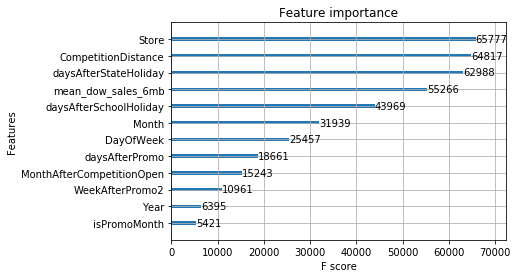

In [64]:
%matplotlib inline
np.set_printoptions(precision=4, threshold=10000, linewidth=200, edgeitems=999, suppress=True)


xgb.plot_importance(bst)

In [65]:
model_aug = bst

In [66]:
# Model for Sep
features_x_sep = ['Store', 'DayOfWeek', 'CompetitionDistance', 'Year', 'Month', 'mean_dow_sales_1m_ago_6mb', 'MonthAfterCompetitionOpen', 'WeekAfterPromo2', 'daysAfterStateHoliday', 'daysAfterSchoolHoliday', 'daysAfterPromo', 'isPromoMonth']

# features_y = ['SalesLog']

# train_val_set['SalesLog'] = np.log1p(train_val_set['Sales'])

# ### Convert Storetype and Assortment to numerical categories
# train_val_set['StateHoliday'] = train_val_set['StateHoliday'].astype('category').cat.codes
# train_val_set['StoreType'] = train_val_set['StoreType'].astype('category').cat.codes
# train_val_set['Assortment'] = train_val_set['Assortment'].astype('category').cat.codes


In [67]:
import xgboost as xgb

# train_set = train_val_set.loc[train_val_set['Date'] < train_val_split_date]
# val_set = train_val_set.loc[train_val_set['Date'] >= train_val_split_date]

X_train_sep = train_set[features_x_sep]
y_train_sep = train_set[features_y]

X_val_sep = val_set[features_x_sep]
y_val_sep = val_set[features_y]

dtrain_sep = xgb.DMatrix(X_train_sep, y_train_sep)
dtest_sep = xgb.DMatrix(X_val_sep, y_val_sep)


In [68]:
num_round = 1000
evallist = [(dtrain_sep, 'train'), (dtest_sep, 'test')]

param_sep = {'max_depth':10,
         'eta':0.01,
         'subsample':0.8,
         'colsample_bytree':0.8, 
         'verbosity':1,
         'objective':'reg:linear',
         'nthread':6}

plst_sep = param_sep.items()

bst_sep = xgb.train(plst_sep, dtrain_sep, num_round, evallist, feval=rmspe_xg, verbose_eval=25, early_stopping_rounds=250)


[16:03:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:8.21397	test-rmse:8.19722	train-rmspe:0.999868	test-rmspe:0.999866
Multiple eval metrics have been passed: 'test-rmspe' will be used for early stopping.

Will train until test-rmspe hasn't improved in 250 rounds.
[25]	train-rmse:6.39084	test-rmse:6.37343	train-rmspe:0.99836	test-rmspe:0.998336
[50]	train-rmse:4.97301	test-rmse:4.95589	train-rmspe:0.99283	test-rmspe:0.992723
[75]	train-rmse:3.86993	test-rmse:3.85201	train-rmspe:0.978363	test-rmspe:0.978007
[100]	train-rmse:3.01227	test-rmse:2.99488	train-rmspe:0.949249	test-rmspe:0.948372
[125]	train-rmse:2.34536	test-rmse:2.32868	train-rmspe:0.901725	test-rmspe:0.899928
[150]	train-rmse:1.82707	test-rmse:1.81132	train-rmspe:0.835885	test-rmspe:0.832637
[175]	train-rmse:1.42424	test-rmse:1.40895	train-rmspe:0.755891	test-rmspe:0.750415
[200]	train-rmse:1.11135	test-rmse:1.09627	train-rmspe:0.66822

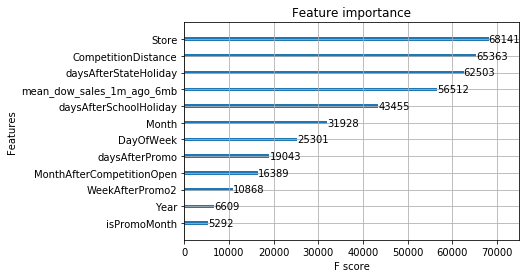

In [69]:
%matplotlib inline
np.set_printoptions(precision=4, threshold=10000, linewidth=200, edgeitems=999, suppress=True)


xgb.plot_importance(bst_sep)

In [51]:
# Testset predict
history_dow_sales_df.head()

,Store,DayOfWeek,Year,Month,Sales
0,1,1,2013,1,5335.500000
1,1,1,2013,2,5471.500000
2,1,1,2013,3,6250.000000
3,1,1,2013,4,5370.000000
4,1,1,2013,5,5397.666667


In [28]:
test_3m_begin = datetime.strptime('2015-05-01', '%Y-%m-%d')
test_6m_begin = datetime.strptime('2015-02-01', '%Y-%m-%d')
test_12m_begin = datetime.strptime('2014-08-01', '%Y-%m-%d')

test_1m_ago_3m_begin = datetime.strptime('2015-04-01', '%Y-%m-%d')
test_1m_ago_3m_end = datetime.strptime('2015-06-30', '%Y-%m-%d')
test_1m_ago_6m_begin = datetime.strptime('2015-01-01', '%Y-%m-%d')
test_1m_ago_6m_end = datetime.strptime('2015-06-30', '%Y-%m-%d')
test_1m_ago_12m_begin = datetime.strptime('2014-07-01', '%Y-%m-%d')
test_1m_ago_12m_end = datetime.strptime('2015-06-30', '%Y-%m-%d')


# history_dow_sales_feature_df
ahead_3m_sales_df = history_dow_sales_df.loc[(history_dow_sales_df['Year'] == 2015) & (history_dow_sales_df['Month'] >=5)]
ahead_3m_dow_sales = ahead_3m_sales_df[['Store', 'DayOfWeek', 'Sales']].groupby(["Store", "DayOfWeek"])['Sales'].mean().reset_index().rename(columns={'Sales': 'mean_dow_sales_3mb'})

ahead_6m_sales_df = history_dow_sales_df.loc[(history_dow_sales_df['Year'] == 2015) & (history_dow_sales_df['Month'] >=2)]
ahead_6m_dow_sales = ahead_6m_sales_df[['Store', 'DayOfWeek', 'Sales']].groupby(["Store", "DayOfWeek"])['Sales'].mean().reset_index().rename(columns={'Sales': 'mean_dow_sales_6mb'})

ahead_12m_sales_df = history_dow_sales_df.loc[(history_dow_sales_df['Year'] >= 2014) & (history_dow_sales_df['Month'] >=8)]
ahead_12m_dow_sales = ahead_12m_sales_df[['Store', 'DayOfWeek', 'Sales']].groupby(["Store", "DayOfWeek"])['Sales'].mean().reset_index().rename(columns={'Sales': 'mean_dow_sales_12mb'})

ahead_1m_ago_3m_sales_df = history_dow_sales_df.loc[(history_dow_sales_df['Year'] == 2015) & (history_dow_sales_df['Month'] >=4) & (history_dow_sales_df['Month'] <=6)]
ahead_1m_ago_3m_dow_sales = ahead_1m_ago_3m_sales_df[['Store', 'DayOfWeek','Sales']].groupby(["Store", "DayOfWeek"])['Sales'].mean().reset_index().rename(columns={'Sales': 'mean_dow_sales_1m_ago_3mb'})

ahead_1m_ago_6m_sales_df = history_dow_sales_df.loc[(history_dow_sales_df['Year'] == 2015) & (history_dow_sales_df['Month'] >=1) & (history_dow_sales_df['Month'] <=6)]
ahead_1m_ago_6m_dow_sales = ahead_1m_ago_6m_sales_df[['Store', 'DayOfWeek','Sales']].groupby(["Store", "DayOfWeek"])['Sales'].mean().reset_index().rename(columns={'Sales': 'mean_dow_sales_1m_ago_6mb'})

ahead_1m_ago_12m_sales_df = history_dow_sales_df.loc[((history_dow_sales_df['Year'] == 2014) & (history_dow_sales_df['Month'] >=7)) | ((history_dow_sales_df['Year'] == 2015) & (history_dow_sales_df['Month'] <=6))]
ahead_1m_ago_12m_dow_sales = ahead_1m_ago_12m_sales_df[['Store', 'DayOfWeek','Sales']].groupby(["Store", "DayOfWeek"])['Sales'].mean().reset_index().rename(columns={'Sales': 'mean_dow_sales_1m_ago_12mb'})


In [67]:
event_feature_df.head()

,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Customers,Date,DayOfWeek,Open,Promo,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Sales,SchoolHoliday,StateHoliday,Store,StoreType,data_type,Year,Month,CompetitionOpenDate,DaysAfterCompetitionOpen,MonthAfterCompetitionOpen,Promo2Since,DaysAfterPromo2,WeekAfterPromo2,isStateHoliday,isSchoolHoliday,isPromo,daysAfterStateHoliday,daysAfterSchoolHoliday,daysAfterPromo,daysBeforeStateHoliday,daysBeforeSchoolHoliday,daysBeforePromo,StateHolidayDay,last_7d_state_holiday,last_7d_school_holiday,last_7d_promo,coming_7d_state_holiday,coming_7d_school_holiday,coming_7d_promo
0,a,1270.0,9,2008,NaN,2015-09-17,4,1.0,1,0,1,1900,NaN,NaN,0,0,1,c,3,2015,9,2008-09-15,2558,24,1900-01-01,0,0,False,False,True,105.0,13.0,0.0,-1.0,-1.0,0.0,0,0.0,0.0,4.0,0.0,0.0,1.0
1,a,1270.0,9,2008,NaN,2015-09-16,3,1.0,1,0,1,1900,NaN,NaN,0,0,1,c,3,2015,9,2008-09-15,2557,24,1900-01-01,0,0,False,False,True,104.0,12.0,0.0,-1.0,-1.0,0.0,0,0.0,0.0,3.0,0.0,0.0,2.0
2,a,1270.0,9,2008,NaN,2015-09-15,2,1.0,1,0,1,1900,NaN,NaN,0,0,1,c,3,2015,9,2008-09-15,2556,24,1900-01-01,0,0,False,False,True,103.0,11.0,0.0,-1.0,-1.0,0.0,0,0.0,0.0,2.0,0.0,0.0,3.0
3,a,1270.0,9,2008,NaN,2015-09-14,1,1.0,1,0,1,1900,NaN,NaN,0,0,1,c,3,2015,9,2008-09-15,2555,24,1900-01-01,0,0,False,False,True,102.0,10.0,0.0,-1.0,-1.0,0.0,0,0.0,0.0,1.0,0.0,0.0,4.0
4,a,1270.0,9,2008,NaN,2015-09-13,7,0.0,0,0,1,1900,NaN,NaN,0,0,1,c,3,2015,9,2008-09-15,2554,24,1900-01-01,0,0,False,False,False,101.0,9.0,9.0,-1.0,-1.0,1.0,0,0.0,0.0,0.0,0.0,0.0,4.0


In [72]:
test_aug_date = datetime.strptime('2015-08-31', '%Y-%m-%d')

test_df['Date'] = pd.to_datetime(test_df['Date'])
test_df['Year'] = test_df['Date'].dt.year
test_df['Month'] = test_df['Date'].dt.month

test_aug = test_df.loc[test_df['Date'] <= test_aug_date][['Id', 'Store', 'Date','DayOfWeek', 'Promo', 'SchoolHoliday', 'StateHoliday', 'StoreType', 'Assortment', 'CompetitionDistance', 'Promo2', 'Year', 'Month', 'PromoInterval']]
test_sep = test_df.loc[test_df['Date'] > test_aug_date][['Id', 'Store', 'Date', 'DayOfWeek', 'Promo', 'SchoolHoliday', 'StateHoliday', 'StoreType', 'Assortment', 'CompetitionDistance', 'Promo2', 'Year', 'Month', 'PromoInterval']]

test_aug = test_aug.merge(ahead_3m_dow_sales, how = 'left', on = ['Store', 'DayOfWeek'])
test_aug = test_aug.merge(ahead_6m_dow_sales, how = 'left', on = ['Store', 'DayOfWeek'])
test_aug = test_aug.merge(ahead_12m_dow_sales, how = 'left', on = ['Store', 'DayOfWeek'])

test_sep = test_sep.merge(ahead_1m_ago_3m_dow_sales, how='left', on = ['Store', 'DayOfWeek'])
test_sep = test_sep.merge(ahead_1m_ago_6m_dow_sales, how='left', on = ['Store', 'DayOfWeek'])
test_sep = test_sep.merge(ahead_1m_ago_12m_dow_sales, how='left', on = ['Store', 'DayOfWeek'])

test_aug.head()

,Id,Store,Date,DayOfWeek,Promo,SchoolHoliday,StateHoliday,StoreType,Assortment,CompetitionDistance,Promo2,Year,Month,PromoInterval,mean_dow_sales_3mb,mean_dow_sales_6mb,mean_dow_sales_12mb
0,14553,1,2015-08-31,1,1,1,0,c,a,1270.0,0,2015,8,,4888.677778,4859.461111,5283.85
1,14554,3,2015-08-31,1,1,0,0,a,a,14130.0,1,2015,8,"Jan,Apr,Jul,Oct",8326.605556,8172.122222,8289.40
2,14555,7,2015-08-31,1,1,0,0,a,c,24000.0,0,2015,8,,11558.333333,10776.583333,11349.47
3,14556,8,2015-08-31,1,1,0,0,a,a,7520.0,0,2015,8,,8089.111111,7952.166667,7576.33
4,14557,9,2015-08-31,1,1,0,0,a,c,2030.0,0,2015,8,,9657.100000,9475.661111,8608.55


In [73]:
test_aug = test_aug.merge(event_feature_df[['Store', 'Date'] + event_features], how='left', on =['Store', 'Date'])
test_sep = test_sep.merge(event_feature_df[['Store', 'Date'] + event_features], how='left', on =['Store', 'Date'])

test_aug.head()


,Id,Store,Date,DayOfWeek,Promo,SchoolHoliday,StateHoliday,StoreType,Assortment,CompetitionDistance,Promo2,Year,Month,PromoInterval,mean_dow_sales_3mb,mean_dow_sales_6mb,mean_dow_sales_12mb,MonthAfterCompetitionOpen,DaysAfterPromo2,WeekAfterPromo2,daysAfterStateHoliday,daysAfterSchoolHoliday,daysAfterPromo,last_7d_state_holiday,last_7d_school_holiday,last_7d_promo
0,14553,1,2015-08-31,1,1,1,0,c,a,1270.0,0,2015,8,,4888.677778,4859.461111,5283.85,24,0,0,88.0,0.0,0.0,0.0,7.0,1.0
1,14554,3,2015-08-31,1,1,0,0,a,a,14130.0,1,2015,8,"Jan,Apr,Jul,Oct",8326.605556,8172.122222,8289.40,24,1610,25,88.0,20.0,0.0,0.0,0.0,1.0
2,14555,7,2015-08-31,1,1,0,0,a,c,24000.0,0,2015,8,,11558.333333,10776.583333,11349.47,24,0,0,98.0,3.0,0.0,0.0,4.0,1.0
3,14556,8,2015-08-31,1,1,0,0,a,a,7520.0,0,2015,8,,8089.111111,7952.166667,7576.33,10,0,0,98.0,3.0,0.0,0.0,4.0,1.0
4,14557,9,2015-08-31,1,1,0,0,a,c,2030.0,0,2015,8,,9657.100000,9475.661111,8608.55,24,0,0,88.0,20.0,0.0,0.0,0.0,1.0


In [74]:
feature_isPromoMonth(test_aug)
feature_isPromoMonth(test_sep)

test_aug.head()

,Id,Store,Date,DayOfWeek,Promo,SchoolHoliday,StateHoliday,StoreType,Assortment,CompetitionDistance,Promo2,Year,Month,PromoInterval,mean_dow_sales_3mb,mean_dow_sales_6mb,mean_dow_sales_12mb,MonthAfterCompetitionOpen,DaysAfterPromo2,WeekAfterPromo2,daysAfterStateHoliday,daysAfterSchoolHoliday,daysAfterPromo,last_7d_state_holiday,last_7d_school_holiday,last_7d_promo,isPromoMonth
0,14553,1,2015-08-31,1,1,1,0,c,a,1270.0,0,2015,8,,4888.677778,4859.461111,5283.85,24,0,0,88.0,0.0,0.0,0.0,7.0,1.0,0
1,14554,3,2015-08-31,1,1,0,0,a,a,14130.0,1,2015,8,"Jan,Apr,Jul,Oct",8326.605556,8172.122222,8289.40,24,1610,25,88.0,20.0,0.0,0.0,0.0,1.0,0
2,14555,7,2015-08-31,1,1,0,0,a,c,24000.0,0,2015,8,,11558.333333,10776.583333,11349.47,24,0,0,98.0,3.0,0.0,0.0,4.0,1.0,0
3,14556,8,2015-08-31,1,1,0,0,a,a,7520.0,0,2015,8,,8089.111111,7952.166667,7576.33,10,0,0,98.0,3.0,0.0,0.0,4.0,1.0,0
4,14557,9,2015-08-31,1,1,0,0,a,c,2030.0,0,2015,8,,9657.100000,9475.661111,8608.55,24,0,0,88.0,20.0,0.0,0.0,0.0,1.0,0


In [76]:
test_sep.groupby('isPromoMonth').size()

isPromoMonth
0    14552
dtype: int64

In [77]:
test_aug['StateHoliday'] = test_aug['StateHoliday'].astype('category').cat.codes
test_aug['StoreType'] = test_aug['StoreType'].astype('category').cat.codes
test_aug['Assortment'] = test_aug['Assortment'].astype('category').cat.codes

test_sep['StateHoliday'] = test_sep['StateHoliday'].astype('category').cat.codes
test_sep['StoreType'] = test_sep['StoreType'].astype('category').cat.codes
test_sep['Assortment'] = test_sep['Assortment'].astype('category').cat.codes


In [78]:
dsubmit_aug = xgb.DMatrix(test_aug[features_x])

ypred_aug = model_aug.predict(dsubmit_aug)

df_ypred_aug = test_aug['Id'].reset_index()
del df_ypred_aug['index']
df_ypred_aug['Id'] = df_ypred_aug['Id'].astype('int')

# Scale back the sales a bit
df_ypred_aug['Sales'] = (np.exp(ypred_aug) - 1)

df_ypred_aug.sort_values('Id', inplace=True)
df_ypred_aug.head()
# df_ypred[['Id', 'Sales']].to_csv('rossmann_best_no_ext_data_scaled.csv', index=False)

,Id,Sales
0,14553,5612.891602
1,14554,10573.906250
2,14555,13723.351562
3,14556,10293.711914
4,14557,11666.829102


In [79]:
dsubmit_sep = xgb.DMatrix(test_sep[features_x_sep])

ypred_sep = bst_sep.predict(dsubmit_sep)

df_ypred_sep = test_sep['Id'].reset_index()
del df_ypred_sep['index']
df_ypred_sep['Id'] = df_ypred_sep['Id'].astype('int')

# Scale back the sales a bit
df_ypred_sep['Sales'] = (np.exp(ypred_sep) - 1)

df_ypred_sep.sort_values('Id', inplace=True)
df_ypred_sep.head()

,Id,Sales
0,1,5236.790039
1,2,9122.601562
2,3,10993.348633
3,4,9966.400391
4,5,9420.091797


In [80]:
test_result = df_ypred_aug.append(df_ypred_sep)

test_result['Id'] = test_result['Id'].astype('int32')

test_result[['Id', 'Sales']].to_csv('kaggle_xgboost_v5_2.csv', index=False)